In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

In [2]:
# economic parameters
beta = 0.7
gamma = 5.0
alpha = 0.3
z_shock = np.exp([-0.25, 0.25])
P = np.array([[0.5, 0.5],
              [0.5, 0.5]])

In [3]:
# system of equations
def euler_equation(kp, k0, z_idx, T):

    # production today
    z0 = z_shock[z_idx]
    w = z0 * (1.0 - alpha) * k0 ** alpha

    # production tomorrow
    yp = z_shock * kp ** alpha
    rp = z_shock * alpha * kp ** (alpha - 1.0) - 1.0

    # consumption today and tomorrow
    c = w - kp - T
    cp = (1 + rp) * kp + T

    # euler equation
    ee_res = c ** (-gamma) - beta * np.sum((1 + rp) * cp ** (-gamma) * P[z_idx, :])

    return ee_res

In [4]:
# solve the model along the simulation
t_end = 200
n_max = 100
T_grid = np.linspace(0, 0.05, n_max)

np.random.seed(12345)
idx_ts = np.random.choice([0, 1], t_end)
k_ts = np.zeros((n_max, t_end))
k_ts[:, 0] = 0.1
r_ts = np.zeros((n_max, t_end))
w_ts = np.zeros((n_max, t_end))
cy_ts = np.zeros((n_max, t_end))
co_ts = np.zeros((n_max, t_end))
u_ts = np.zeros((n_max, t_end))
for i in range(n_max):
    for t in range(t_end-1):
        # solve system of equations given the current capital stock
        lb = 0.01
        ub = 0.99 * (z_shock[idx_ts[t]] * (1.0 - alpha) * k_ts[i, t] ** alpha - T_grid[i])
        sol = scipy.optimize.root_scalar(euler_equation, bracket=[lb, ub], args=(k_ts[i, t], idx_ts[t], T_grid[i]), method='brentq')
        k_ts[i, t+1] = sol.root

        # compute factor prices and consumption
        r_ts[i, t] = z_shock[idx_ts[t]] * alpha * k_ts[i, t] ** (alpha - 1) - 1
        w_ts[i, t] = z_shock[idx_ts[t]] * (1 - alpha) * k_ts[i, t] ** alpha
        cy_ts[i, t] = w_ts[i, t] - k_ts[i, t + 1] - T_grid[i]
        co_ts[i, t] = (1 + r_ts[i, t]) * k_ts[i, t] + T_grid[i]

        # compute ex-ante utility
        r_tom = z_shock * alpha * k_ts[i, t+1] ** (alpha - 1.0) - 1.0
        co_tom = (1 + r_tom) * k_ts[i, t+1] + T_grid[i]
        u_ts[i, t] = 1 / (1 - gamma) * cy_ts[i, t] ** (1-gamma) + beta / (1 - gamma) * np.sum(P[idx_ts[t], :] * co_tom ** (1-gamma))

Optimal Transfer: 0.025252525252525252


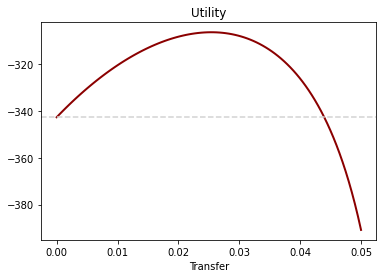

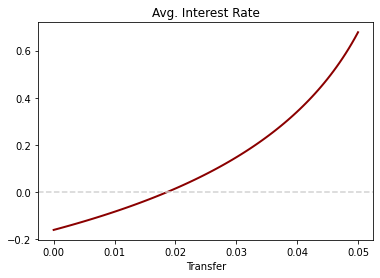

In [5]:
# steady state utility comparison
plt.figure()
plt.plot(T_grid, np.mean(u_ts[:, 100:], axis=1), color='darkred', linewidth=2)
plt.axhline(y=np.mean(u_ts[0, 100:]), color='lightgrey', linestyle='dashed')
plt.xlabel('Transfer')
plt.title('Utility')

plt.figure()
plt.plot(T_grid, np.mean(r_ts[:, 100:], axis=1), color='darkred', linewidth=2)
plt.axhline(y=0.0, color='lightgrey', linestyle='dashed')
plt.xlabel('Transfer')
plt.title('Avg. Interest Rate')

idx_opt = np.argmax(np.mean(u_ts[:, 100:], axis=1))
print('Optimal Transfer: ' + str(T_grid[idx_opt]))

plt.show()